In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import imageio
import numpy as np
import matplotlib
import mlflow
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from models.model_factory import model_factory
from transformations.transform_factory import transform_factory
from loader import loader
import pickle
import random
from pycocotools.coco import COCO
matplotlib.style.use('ggplot')

# specify dataset name
ds_name = "coco"

# learning parameters
batch_size = 32
epochs = 2
sample_size = 2 # fixed sample size
nz = 16 # latent vector size
k = 1 # number of steps to apply to the discriminator
model_save_interval = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# parameter for our approach "Text to Images"
textToImage = False
embed_dict = None
embed_dim = None
embeddings = None
if textToImage:
    if ds_name != 'coco':
        # load dict for mnist and cifar embeddings
        with open('./fasttext/' + ds_name + '_embeddings.pickle', 'rb') as fin:
            embed_dict = pickle.load(fin)
        embed_dim = embed_dict[0].size
    else: 
        
        #TODO 
        # 0. select between loading with pytorch or pycocotools.coco
        # 1. select ids from category-> same as cifar
        # 2. sample random IDs for training
        # -> preprocess fixed ids?
        # 3 select from 5 caption which ones are used for training
        # 4 select captions for training
        # 5 generate word embedding:
        #   - fasttext
        #   - distilbert
        # 6. test on cifar10 architecture
        # 7. implement coco architecture
        pass
    
mlflow.set_experiment(ds_name)
mlflow.end_run()
mlflow.start_run()
mlflow_experiment_id = mlflow.get_experiment_by_name(ds_name).experiment_id
mlflow_run_id = mlflow.active_run().info.run_id
log_path = "mlruns/"+str(mlflow_experiment_id)+"/"+str(mlflow_run_id)+"/"+"artifacts"+"/"
mlflow.log_param("run_id", mlflow_run_id)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)
mlflow.log_param("sample_size", sample_size)
mlflow.log_param("nz", nz)
mlflow.log_param("k", k)
mlflow.log_param("flag_textToImage", textToImage)
mlflow.log_param("device", device)
mlflow.log_param("model_save_interval", model_save_interval)
print("mlflow logpath:"+log_path)


transform =  transform_factory.transform_factory(ds_name).get_compose()
to_pil_image = transforms.ToPILImage()

if ds_name != 'coco':
    train_data = loader(ds_name, transform).getDataset()
else:
    train_data = loader(ds_name, transform, textToImage, ['cat'], sample_size).getDataset()
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

generator = model_factory.generator_factory(ds_name, nz, textToImage, embed_dim).to(device)
discriminator = model_factory.discriminator_factory(ds_name, textToImage, embed_dim).to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss() #binary cross entropy

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake, embedding):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real, embedding)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake, embedding)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake, embedding):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake, embedding)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss    

# map labels to the corresponding labels of CIFAR10, MNIST or FMNIST
# TODO expand for COCO sentences
def get_embeddings(labels):
    embeddings = [embed_dict[int(label.detach())] for label in labels]
    embeddings = np.array(embeddings)
    return torch.from_numpy(embeddings)

# generates random labels from range(10).
# Used for MNIST, FMNIST and CIRFAR
def create_random_labels(sample_size):
    random_labels = np.random.choice(10,(sample_size))
    random_embed =  [embed_dict[int(label)] for label in np.nditer(random_labels)]
    random_embed = np.array(random_embed).reshape(sample_size, -1)
    return torch.from_numpy(random_embed).to(device)

# create the noise vector and labels
noise = create_noise(sample_size, nz)
if textToImage:
    # generate random labels for testing
    embeddings = create_random_labels(sample_size)

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    embed_batch = None
    for bi, data in enumerate(train_loader):
        if textToImage:
            image, labels = data
            embed_batch = get_embeddings(labels).to(device)
        else:
            image, _ = data
            
        image = image.to(device)
        b_size = len(image)
        
#         run the discriminator for k number of steps
        for step in range(k):

            data_fake = generator(create_noise(b_size, nz), embed_batch).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake, embed_batch)

        data_fake = generator(create_noise(b_size, nz), embed_batch)
        # train the generator network
        loss_g += train_generator(optim_g, data_fake, embed_batch)

    # create the final fake image for the epoch
    generated_img = generator(noise, embeddings).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, log_path+"gen_img"+str(epoch)+".png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.cpu().detach().numpy())
    losses_d.append(epoch_loss_d.cpu().detach().numpy())
    
    mlflow.log_metric("loss_generator", losses_g[-1].item())
    mlflow.log_metric("loss_discriminator", losses_d[-1].item())  
    if epoch % model_save_interval == 0: #each model is 60mb in size
        torch.save(generator.state_dict(), log_path+"generator"+str(epoch)+".pth")
        torch.save(discriminator.state_dict(), log_path+"discriminator"+str(epoch)+".pth")
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(log_path+'generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g , label='Generator loss')
plt.plot(losses_d , label='Discriminator Loss')
plt.legend()
plt.savefig(log_path+'loss.png')

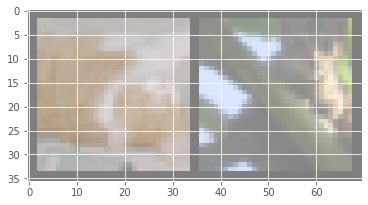

In [4]:
import matplotlib.pyplot as plt
import torchvision

#visualize COCO transformation
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

im = []
for bi, data in enumerate(train_data):
    print(bi)
    img, labels = data
    print(img.shape)
    im.append(img)
imglist = [im[0], im[1]]

plt.imshow(imshow(torchvision.utils.make_grid(imglist)))# 4D mini-batch Tensor of shape (B x C x H x W)-> torch.Size([4, 3, 32, 32])